## Plan of Work

##### I am going to divide the work in a few steps:
    1. The first thing I want to do is get to know the data and its health: are there missing values, are the outliers, do I need to fix anything or be aware of anything.
    2. Next, I want to uderstand how each feature affects or relates to the target. Is there collinearity/multicollinearity? Should I use all features or can I omit some? Can I reduce dimensionality?
    3. Once I have an understanding of the data and the features, I'm going to try a few predictive models:
        3.1. Recursive Feature Elimination model that checks the most important features
        3.2. Regular multivariate linear regression
        3.3. Ridge regression
        3.4. Lasso regression
        3.5. Polynomial regression
        3.6. XGBoost regression decision tree. I am also testing a polynomial version of the XGBoost regression tree, and a reduced feature model that only includes the features found in 3.1. RFE
    I want to see ridge and lasso regressions' results because these features are not named and could be anything. If an unnecessary feature gets some coefficients with the regression, Ridge is going to make them smaller and closer to 0 and Lasso is going to make them 0
         

## General Insights

    1. There are no missing values and no outliers
    2. There is no multicollinearity between features
    3. Some features have high variance
    4. There is an indication for non-linear relationships
    5. Only 4 features seem to be somewhat positively correlated to the target
    6. We cannot easily reduce the dimensionality of the data
    7. Ridge and Lasso regressions do not increase the regular linear regression model's R squared metric
    8. The XGBoost regression decision tree has much higher R squared than the linear regression models
    9. Polynomial linear models with degrees = 2 increase the linear models' R squared metric but it lowers the XGBoost model's R squared
    10. We tested a Recursive Feature Elimination linear model to see which features are the most important
    10. In all 4 models we tested, the feature importance returns the same important features, which mached the RFE model
    11. The training and predicted target features have similar distributions
    12. Using only the important features in a new XGBoost regression model increases the R squared a bit, but without enough knowledge in the underlying data and what the features are, I'm not certain weather I should discard the rest of the features

# 1. Data Health Check

### Import Libraries

In [1]:
## Let's import the libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats ## we use this library to build the QQ plots to check for normal distribution
from scipy.stats import zscore ## we use this library to decide whether there are outliers in the dataset
from scipy.stats import shapiro ## we use this library to check for normal distribution
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score ## we use this library to split the data
from sklearn.linear_model import LinearRegression ## we use this library to build linear models
from sklearn.metrics import mean_squared_error, r2_score ## this library has the accuracy metrics
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor ## we use this library to check for multicolinearity
from sklearn.feature_selection import RFE

### Set the Charts Look

In [9]:
## Let's set the look of the charts

sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(18,10)})
sns.set(font_scale = 2)

### Load the Datasets

In [4]:
## Let's import the datasets

train_df = pd.read_csv('training_data.csv')
test_df = pd.read_csv('blind_test_data.csv')

### Check for missing values

In [5]:
## Let's see if there are empty values in the dataset

train_df.isnull().sum()

feature_0     0
feature_1     0
feature_2     0
feature_3     0
feature_4     0
feature_5     0
feature_6     0
feature_7     0
feature_8     0
feature_9     0
feature_10    0
feature_11    0
feature_12    0
feature_13    0
feature_14    0
feature_15    0
feature_16    0
feature_17    0
feature_18    0
feature_19    0
target        0
dtype: int64

#### Great, no empty values. All columns are number columns

In [6]:
## We want to see all columns and rows and not see concatenated values

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

### Data Spread

In [7]:
## Let's see the spread of the dataset: mean, median, standard deviation, minimum and maximum, etc

train_df.describe()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,target
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,468.181612,301.960218,317.132996,283.213456,485.975950,320.953859,217.136330,387.196289,179.485453,196.003058,401.079696,3.372667,479.841915,100.112096,28.334725,277.205999,91.217615,70.927129,27.385266,457.016407,14.631342
std,270.797415,170.691136,176.501920,157.698215,272.594030,185.157189,123.660691,235.131376,104.059309,111.042671,228.533579,1.986369,276.304197,59.149794,16.105155,167.385930,53.950523,40.588905,15.509062,270.650146,5.089503
min,0.916648,0.800119,0.173025,0.308823,0.598527,0.997347,0.402436,0.474825,0.727850,0.264253,1.487605,0.004464,1.706240,0.194306,0.222312,1.726915,0.093789,0.072986,0.101761,0.252919,0.279805
25%,239.330140,157.338244,167.516318,151.302826,250.305362,158.374610,106.876625,195.037853,94.220273,95.052359,200.478981,1.630150,249.560260,48.132939,14.660437,131.516567,44.357970,34.903031,13.815298,221.270792,10.879914
50%,477.750620,303.257176,326.310194,294.574403,493.470486,328.722464,217.098090,364.124238,173.364771,199.587048,413.806417,3.349497,468.536888,100.247827,27.953146,275.950814,87.484343,74.429675,27.766111,462.153497,14.687955
75%,704.650292,448.878174,474.484472,415.806162,720.747672,480.076559,327.411334,588.565017,268.790459,291.546642,614.042096,5.024192,713.291136,149.966755,42.514155,423.110446,137.888018,105.484961,40.402938,688.352373,18.224713
max,940.771543,595.359858,614.271632,549.896216,950.017444,638.199832,426.308251,809.346792,367.084755,384.919108,767.311089,6.859269,979.715063,203.122292,56.467485,566.611509,187.041256,138.675389,53.254740,935.740775,27.360789


#### From the table above, we can see that only a few columns (feature_11, feature_14, feature_15) have relativey small standard deviations. Let's further visualize the spread and the differences with boxplots

### Boxplots to Check Data Spread

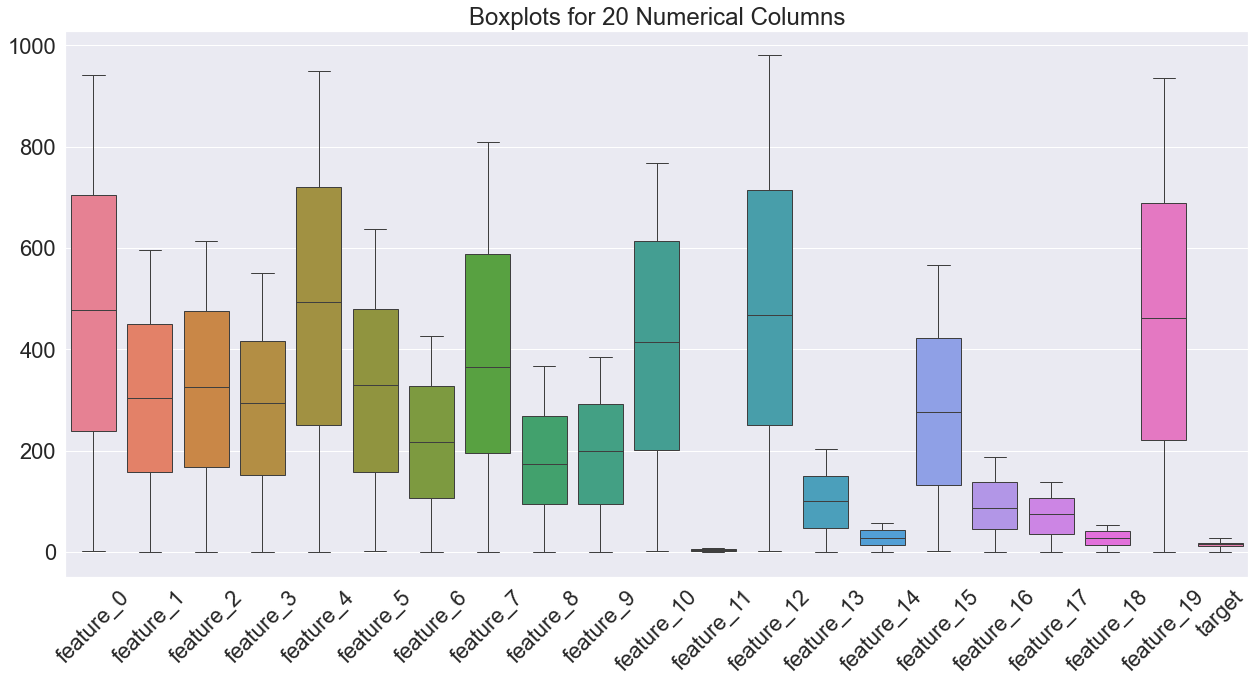

In [10]:
sns.boxplot(data=train_df)

# Name the chart and set the labels to 45 degree angle
plt.title('Boxplots for 20 Numerical Columns')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

#### The boxplots show us that some features have similar behavior. For example, feature_0, feature_4, feature_10, feature_12, and feature_19 have similar means and the body of the boxplot is spread out, which means they have similar variability and the data is spread out.
#### Features 1 through 3, feature_5,feature_7, feature_9 are different than the first group and form a second group with similar means and data spread.
#### A third group is formed by feature_6, feature_8 and feature_9, and then feature_13, feature_16 and feature_17 form a third group.
#### The high variance in some features indicates possible non-linearity in the data and the need for using more complex models


### Outliers Check

In [11]:
## Let's do a z-score check for outliers. If the z-score > 3, the point is an outlier
z_scores = np.abs(zscore(train_df))

In [12]:
# If threshold is greater than 3, it's an outlier
threshold = 3

# Identify outliers
outliers = (z_scores > threshold)

In [13]:
# Count the number of outliers in each feature
num_outliers_per_feature = np.sum(outliers, axis=0)

# We store the number of outliers per feature and the feature in a dictionary
outliers_summary = pd.DataFrame({
    'Feature': train_df.columns,
    'Number_of_Outliers': num_outliers_per_feature,
    'Percentage_of_Outliers': (num_outliers_per_feature / len(train_df)) * 100
})

print(outliers_summary)


               Feature  Number_of_Outliers  Percentage_of_Outliers
feature_0    feature_0                   0                     0.0
feature_1    feature_1                   0                     0.0
feature_2    feature_2                   0                     0.0
feature_3    feature_3                   0                     0.0
feature_4    feature_4                   0                     0.0
feature_5    feature_5                   0                     0.0
feature_6    feature_6                   0                     0.0
feature_7    feature_7                   0                     0.0
feature_8    feature_8                   0                     0.0
feature_9    feature_9                   0                     0.0
feature_10  feature_10                   0                     0.0
feature_11  feature_11                   0                     0.0
feature_12  feature_12                   0                     0.0
feature_13  feature_13                   0                    

#### There are no outliers in our data

### Data Distribution, Is It Normal?

In [14]:
## let's see the distribution. We are going to see histograms and Quantile-Quantile plots for all features

### Histograms

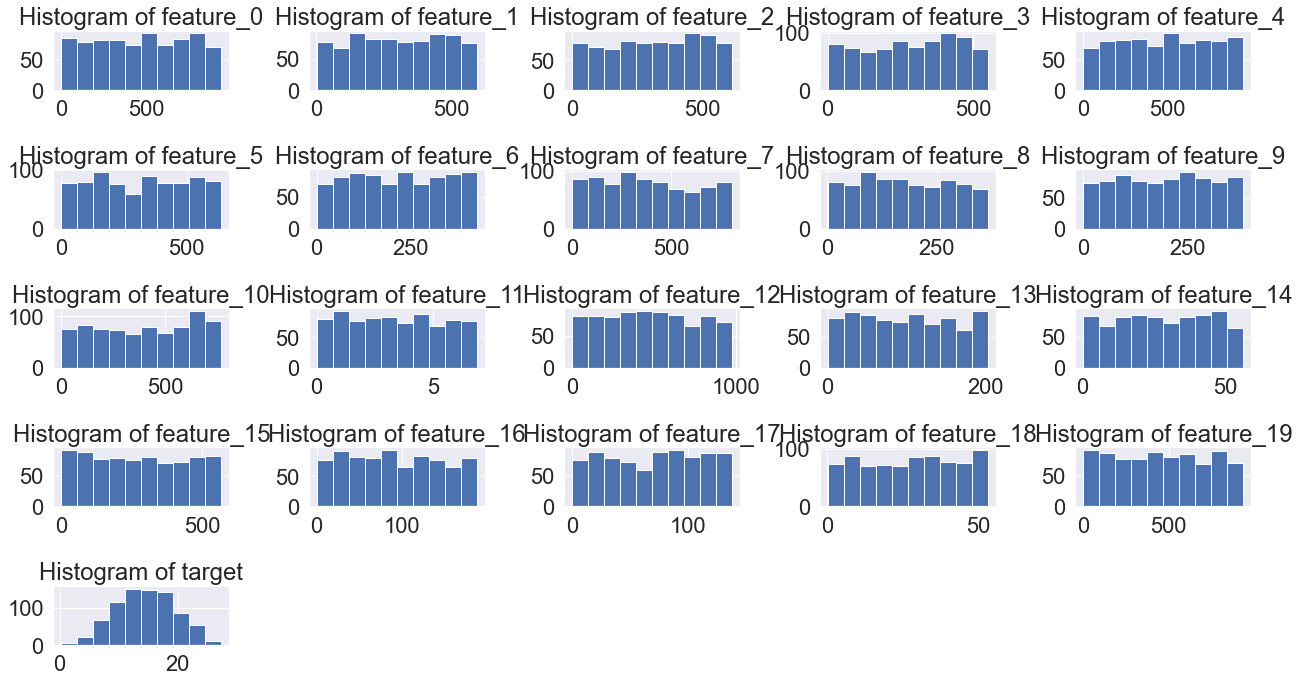

In [15]:
## We want to show charts for all features at once, so we are going to loop through each column and build a histogram for each one

for i, column in enumerate(train_df.columns, 1):
    plt.subplot(5, 5, i)  # This creates a grid of 5 rows and 5 columns to display our 21 features
    train_df[column].hist()  # We are not setting the bin number
    plt.title(f'Histogram of {column}')
    plt.tight_layout()  

plt.show()

#### We do the same thing but build QQ plots. To visualize them better, we plot the features in 2 batches: the first 10 features first and then the next 11


### QQ plots

#### Information on QQ plots: A Quantile-quantile plot compares the quantiles of a feature’s distribution to the quantiles of a normal distribution. If the points fall on a straight line, the feature is normally distributed. Deviations from the line indicate deviations from normality

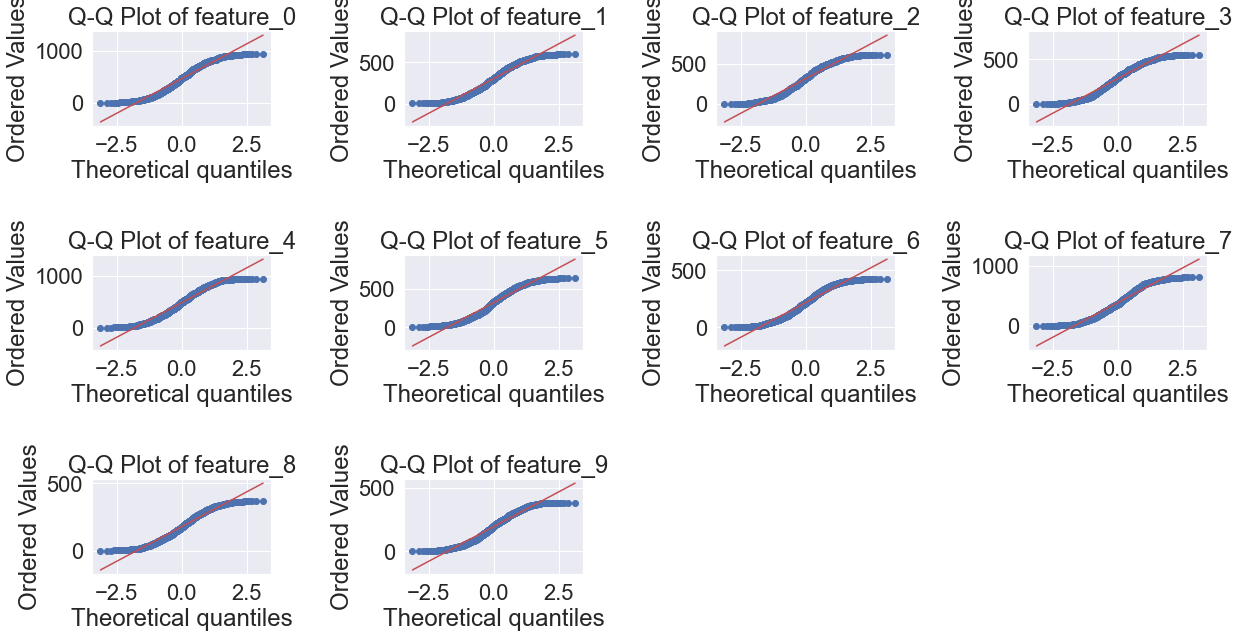

In [16]:
## First 10 features
for i, column in enumerate(train_df.columns[:10], 1):
    plt.subplot(3, 4, i)  
    stats.probplot(train_df[column], dist="norm", plot=plt) 
    plt.title(f'Q-Q Plot of {column}')
    plt.tight_layout(pad=2.0)  

plt.show()

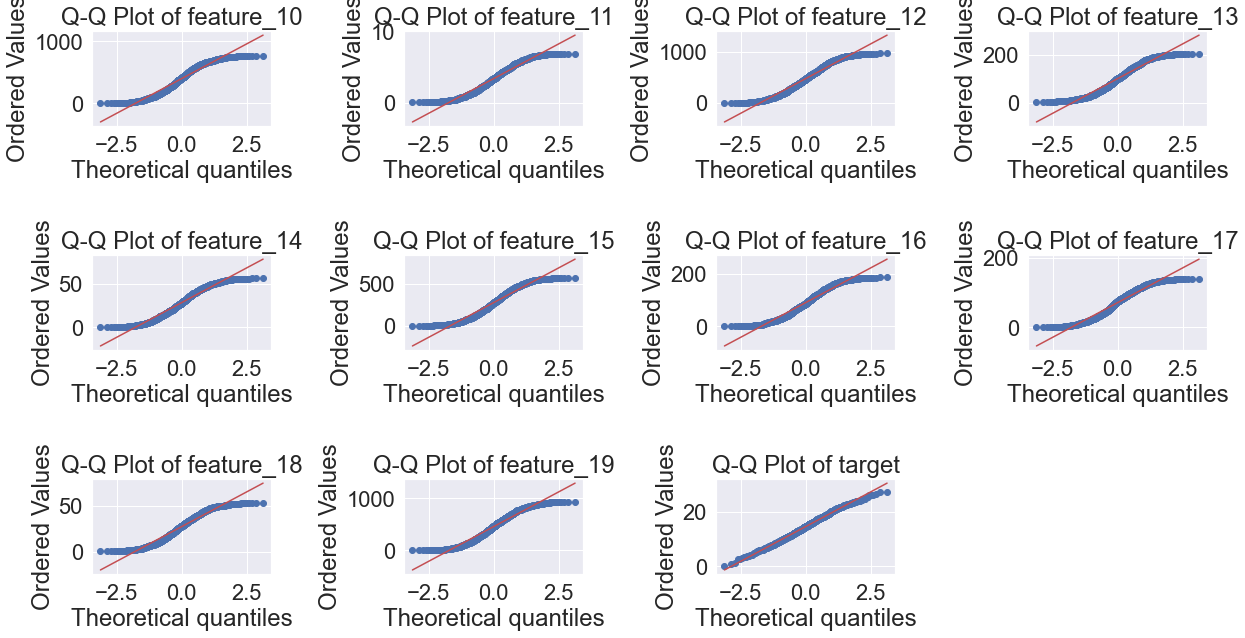

In [17]:
## Second 10 features
for i, column in enumerate(train_df.columns[10:], 1):
    plt.subplot(3, 4, i)  
    stats.probplot(train_df[column], dist="norm", plot=plt) 
    plt.title(f'Q-Q Plot of {column}')
    plt.tight_layout(pad=2.0) 

plt.show()

### Shapiro Test

#### Information on the Shapiro Test: this is a statistical test that checks if a feature is normally distributed. It outputs a p-value, and if the p-value is below 0.05, the feature is not normally distributed.

In [18]:
## Finally, let's use the Shapiro test to check for normal distribution

# We are going to store the results in a dictionary
shapiro_results = {}

for column in train_df.columns:
    stat, p_value = stats.shapiro(train_df[column])  
    shapiro_results[column] = {
        'Statistic': round(stat, 5), 
        'P-Value': round(p_value, 5)
    }

# We convert the dictionary to a dataframe
results_df = pd.DataFrame(shapiro_results).T
results_df.columns = ['Test Statistic', 'P-Value']

# Print the results
print(results_df)

            Test Statistic  P-Value
feature_0          0.95390  0.00000
feature_1          0.95642  0.00000
feature_2          0.95386  0.00000
feature_3          0.95505  0.00000
feature_4          0.95752  0.00000
feature_5          0.94960  0.00000
feature_6          0.95203  0.00000
feature_7          0.95359  0.00000
feature_8          0.95819  0.00000
feature_9          0.95536  0.00000
feature_10         0.94312  0.00000
feature_11         0.95521  0.00000
feature_12         0.95963  0.00000
feature_13         0.95123  0.00000
feature_14         0.95529  0.00000
feature_15         0.95030  0.00000
feature_16         0.95509  0.00000
feature_17         0.95012  0.00000
feature_18         0.95187  0.00000
feature_19         0.95425  0.00000
target             0.99430  0.00415


#### From these three tests, we can conclude that the features are not normally distributed

### Data Normalization

#### We are going to normalize the features so we can use them in the Principle Component Analysis to see if we can reduce dimensionality

In [19]:
## Let's normalize the features

# We initialize the StandardScaler
scaler = StandardScaler()

# We fit the standard scaler to our training data
train_df_standardized = pd.DataFrame(scaler.fit_transform(train_df), columns=train_df.columns)

In [20]:
train_df_standardized.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,target
0,-0.131936,-0.073789,0.930785,0.479329,1.162466,-0.779245,-1.169156,1.420405,-1.376593,-1.011362,1.131006,0.510386,0.133804,-1.361594,-0.942666,-1.403947,-1.025603,-1.236854,-0.875582,-0.268112,-0.052380
1,0.182592,0.167003,1.523809,-1.653109,-1.160555,0.079159,0.544694,1.535867,-1.017210,1.461110,-1.707787,1.103540,-1.727010,-1.343029,-0.658247,-1.646802,1.416228,0.112553,-1.606794,-0.566789,1.052521
2,-1.029983,1.476856,-0.857746,-0.512359,-1.135292,0.001087,1.538573,-0.961556,0.988358,0.230396,-1.125966,0.586502,0.369323,0.026788,-1.719850,1.253297,0.487305,-1.590263,-0.430466,-1.605898,-0.331672
3,-0.853103,-0.621776,0.564762,1.177132,0.461478,-0.105610,0.200224,-1.436688,-0.548959,-1.641610,1.208815,1.081190,-1.574711,1.628046,1.199359,0.802291,-0.446532,1.102069,-1.190843,-0.254273,0.031673
4,0.497597,-1.675751,-0.540689,0.396905,0.266542,-0.239134,1.544975,-1.565234,-0.391519,-0.444619,-0.391137,-0.622858,-1.253937,1.649769,-0.127784,-0.992809,1.501638,0.368373,0.203401,0.624500,-0.556140


# 2. Feature / Target Relationships

### Multicollinearity Checks

#### We are going to check the correlation matrix, the variance inflation factor, and the condition number

### Correlation Matrix

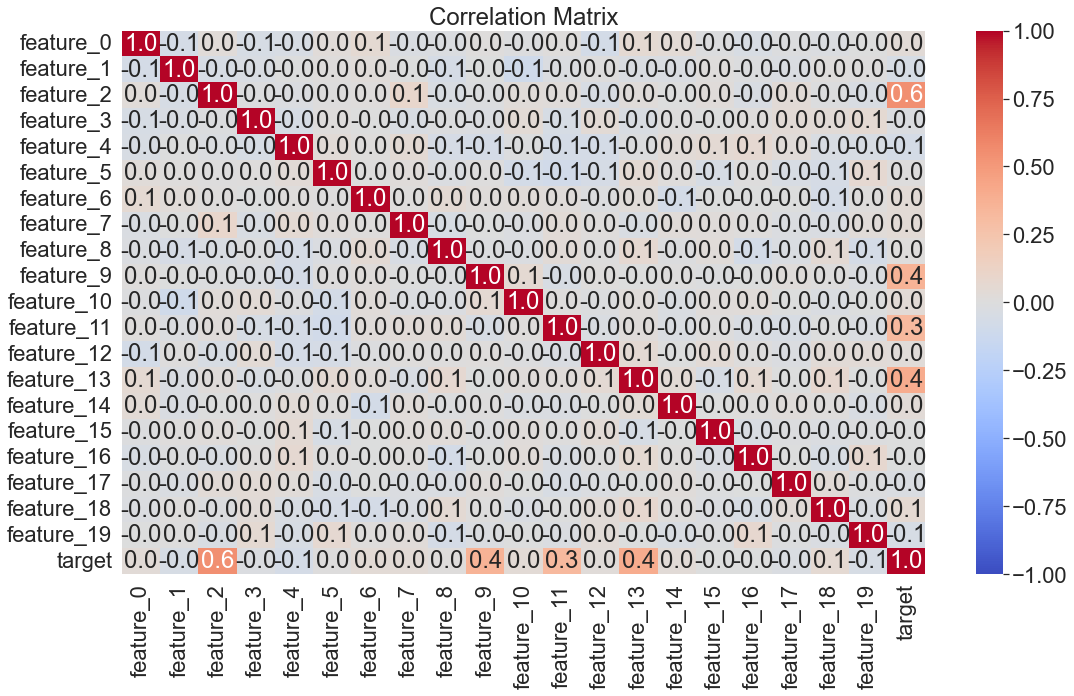

In [21]:
## Let's first see whether any features are correlated
## First, let's plot a correlation matrix

# Compute the correlation matrix
corr_matrix = train_df_standardized.corr()

# Plot the correlation matrix
sns.heatmap(corr_matrix, annot=True, fmt='.1f', cmap='coolwarm', vmin=-1, vmax=1) ## the fmt='.1f' part formats the correlation values to 1 decimal number
plt.title('Correlation Matrix')
plt.show()

#### From the correlation matrix, we can see slight correlations between the target variable and feature_2, feature_9, feature_11, and feature_13

### Variance Inflation Factor (VIF)

#### Information on VIF: It measures how much the variance of a regression coefficient is inflated due to multicollinearity with other predictors. It quantifies the degree of correlation between a predictor and the other predictors in the model.
#### VIF = 1: No correlation with other features.
#### 1 < VIF < 5: Moderate correlation
#### VIF > 10: High multicollinearity

In [22]:
# We first need to add a constant to the features for the VIF calculation
X_standardized = train_df_standardized.copy()
X_standardized = pd.concat([pd.Series(1, index=X_standardized.index, name='Intercept'), X_standardized], axis=1)

# Then we get the VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X_standardized.columns
vif_data['VIF'] = [variance_inflation_factor(X_standardized.values, i) for i in range(X_standardized.shape[1])]

print(vif_data)


       Feature       VIF
0    Intercept  1.000000
1    feature_0  1.030876
2    feature_1  1.026388
3    feature_2  2.025550
4    feature_3  1.024734
5    feature_4  1.040163
6    feature_5  1.037286
7    feature_6  1.021914
8    feature_7  1.021663
9    feature_8  1.032985
10   feature_9  1.509416
11  feature_10  1.027776
12  feature_11  1.380144
13  feature_12  1.032158
14  feature_13  1.537657
15  feature_14  1.018629
16  feature_15  1.016457
17  feature_16  1.027909
18  feature_17  1.017245
19  feature_18  1.029838
20  feature_19  1.027086
21      target  3.391668


### Condition Number

#### Information on the condition number: It measures the overall sensitivity of the matrix to errors. A high condition number indicates high multicollinearity.
#### Condition Number < 30: Generally acceptable; low multicollinearity.
#### 30 < Condition Number < 100: Moderate multicollinearity
#### Condition Number > 100: High multicollinearity or severe issues.

In [23]:
# Get the condition number of the feature matrix
condition_number = np.linalg.cond(train_df_standardized.values)
print(f'Condition Number: {condition_number}')

Condition Number: 3.4398042618806737


#### From these checks, we can conclude that we do not have multicollinearity 

### Pairwise Scatterplots of Features vs Target

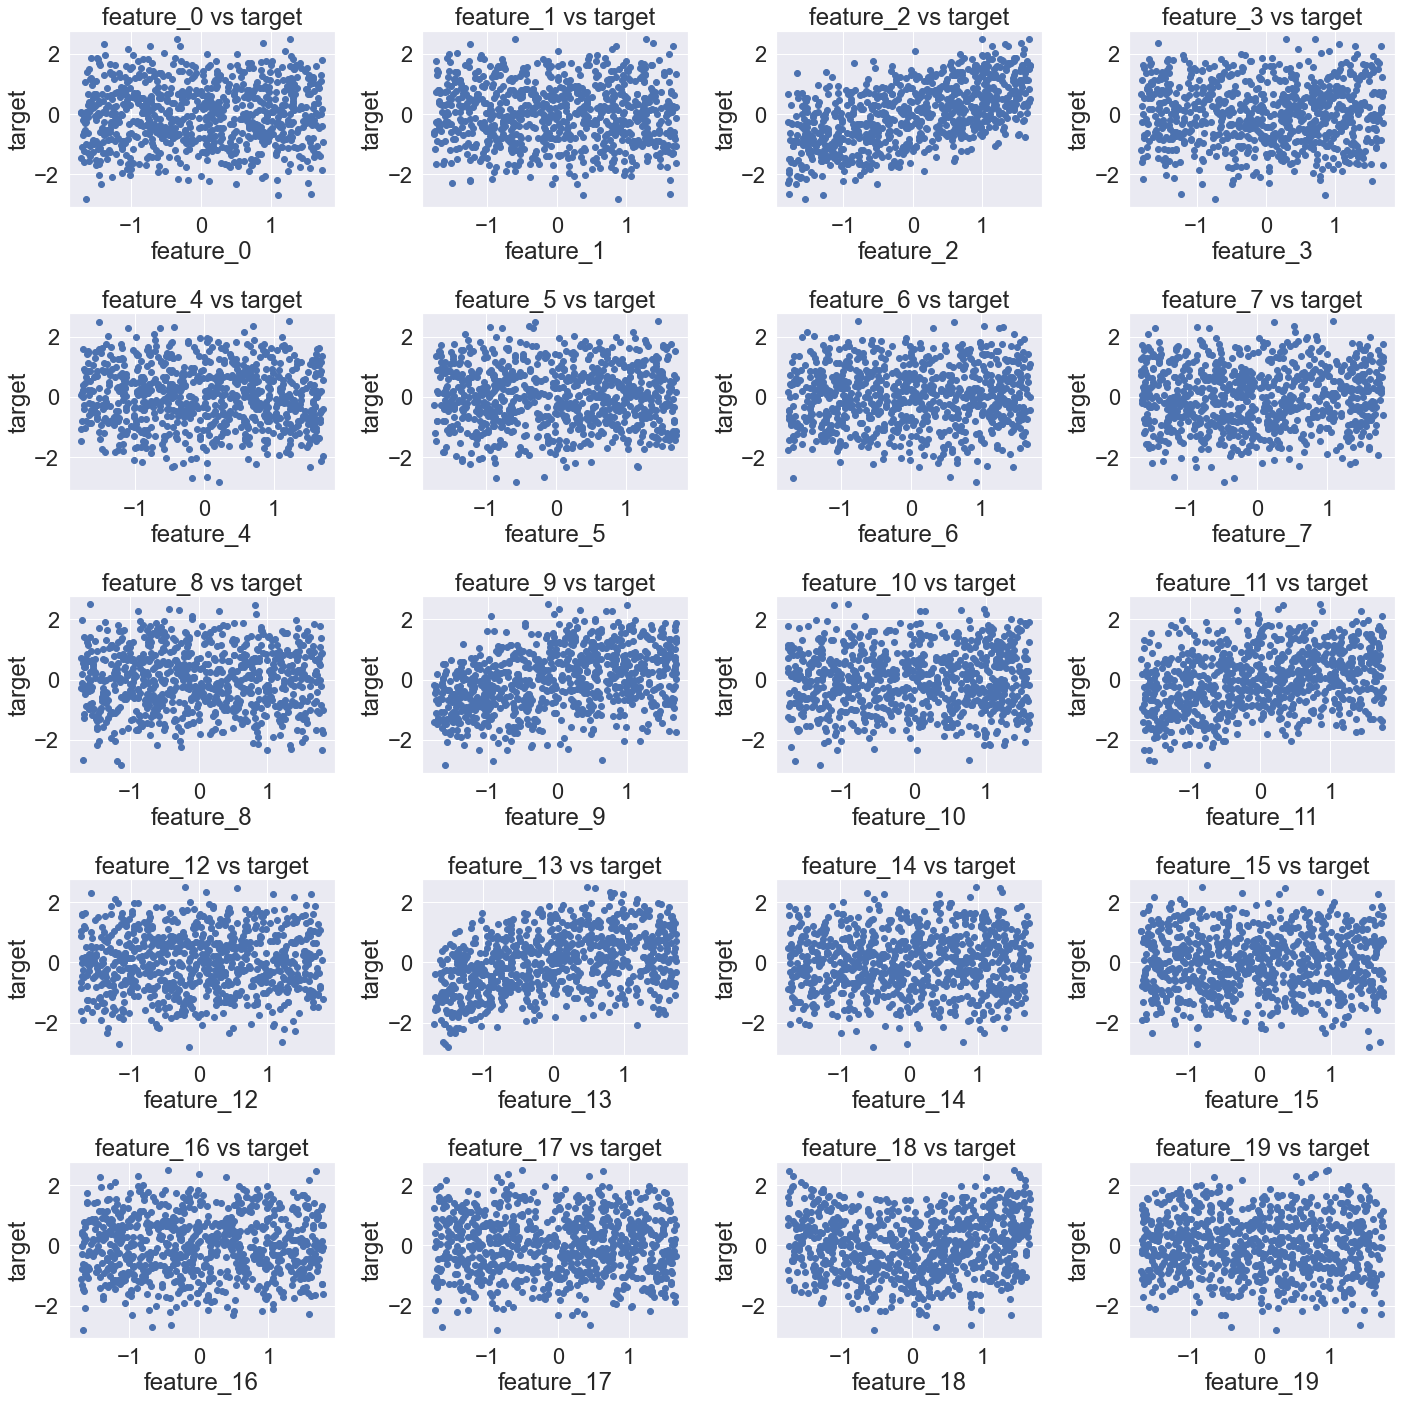

In [24]:
features = train_df_standardized.columns[:-1]  # We drop the target variable
target = train_df_standardized.columns[-1]     # The last column is the target variable

# We create a figure to display all the charts
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 20))
axes = axes.flatten() 

# We plot scatterplots for all features
for i, feature in enumerate(features):
    axes[i].scatter(train_df_standardized[feature], train_df_standardized[target])
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel(target)
    axes[i].set_title(f'{feature} vs {target}')

plt.tight_layout()
plt.show()


### Principle Component Analysis

#### Next, let's do the Principle Component Analysis to see if we can reduce the dimensionality. We will do the elbow method to see how many components the PCA should have

In [25]:
train_df_standardized = train_df_standardized.astype(int)

In [26]:
columns_to_exclude = ['target']
X_standardized = train_df_standardized.loc[:, ~train_df_standardized.columns.isin(columns_to_exclude)]

In [27]:
# We need to initialize the PCA
pca = PCA()

# Then fit the PCA on the scaled data
pca.fit(X_standardized)

PCA()

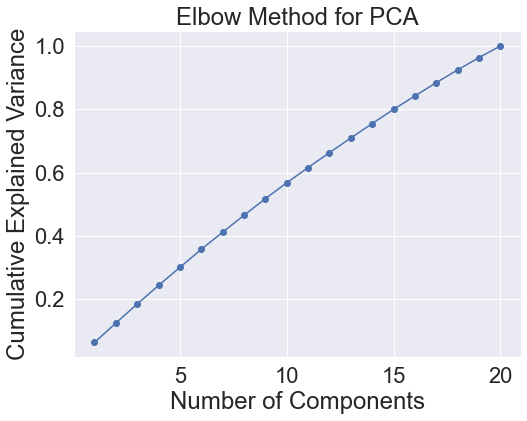

In [28]:
# Calculate the explained variance ratio
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Plot the explained variance ratio and see how many components are optimal
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Elbow Method for PCA')
plt.grid(True)
plt.show()

#### The elbow method suggests that we cannot easily reduce the dimensionality of our data

In [29]:
pca.explained_variance_ 

array([0.54229919, 0.51752025, 0.50898955, 0.49512522, 0.48276715,
       0.48174795, 0.45661708, 0.45089939, 0.44358716, 0.42336531,
       0.40597082, 0.3986458 , 0.39218369, 0.38415309, 0.3779597 ,
       0.35855993, 0.35534302, 0.33981086, 0.32810639, 0.31157219])

In [30]:
# Proportion of Variance (from PC1 to PC20)
pca.explained_variance_ratio_

array([0.06413777, 0.06120716, 0.06019824, 0.0585585 , 0.05709691,
       0.05697637, 0.05400414, 0.05332791, 0.05246309, 0.05007145,
       0.0480142 , 0.04714787, 0.0463836 , 0.04543382, 0.04470132,
       0.04240691, 0.04202645, 0.04018946, 0.03880517, 0.03684967])

#### We can see the cumulative explained variance by number of components on the chart below

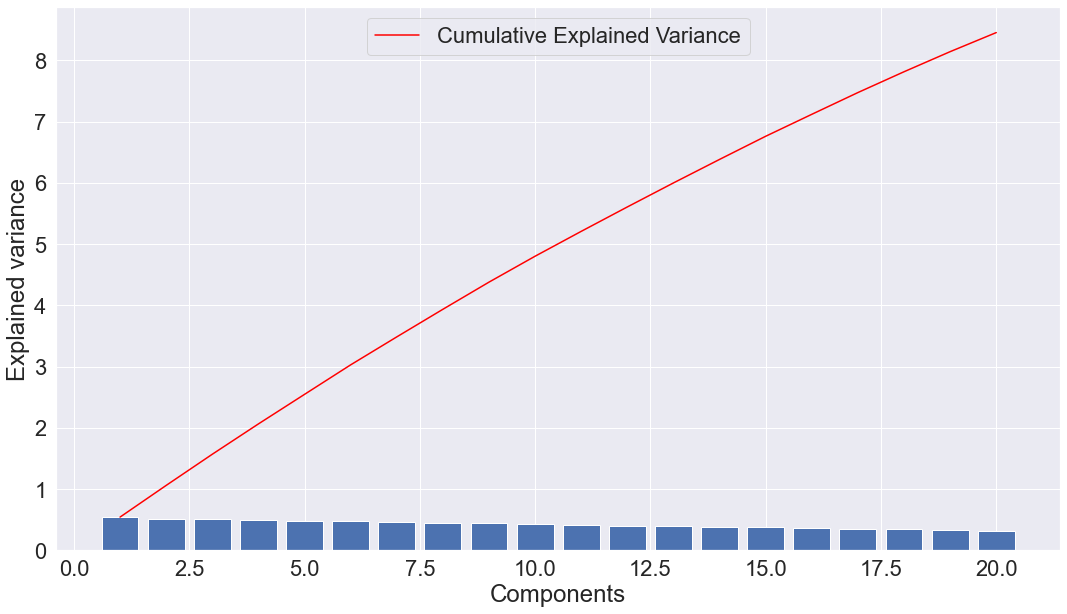

In [31]:
plt.bar(range(1,len(pca.explained_variance_ )+1),pca.explained_variance_ )
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1,len(pca.explained_variance_ )+1),
         np.cumsum(pca.explained_variance_),
         c='red',
         label="Cumulative Explained Variance")
plt.legend(loc='upper center')

# 3. Predictive Models

#### In this section, we are going to build and compare a few multivariate regression models. __First,__ we are going to create a Recursive Feature Elimination model and note the most important features it returned. __Then,__ we are going to create a linear regression, a Ridge regression, Lasso regression, and polynomial versions of each of these models. __Next,__ we are going to create an XGBoost regression decision tree and compare it to the linear regression models. We will __also build__ a polynomial XGBoost model, and an XGBoost model that only uses the features that the RFE returned in this section's first step 

In [32]:
# We are splitting the dataset to training features (X) and a target variable (y)
X = train_df.loc[:, ~train_df.columns.isin(columns_to_exclude)]
y = train_df['target']

In [33]:
# We split the data to 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

### Recursive Feature Elimination

#### Information on RFE: This iss a feature selection technique that identifies the most important features in a dataset using the model's coefficients. RFE ranks features by importance and selects the most relevant subset of features for the model.

In [34]:
model = LinearRegression()

# Define RFE with the model
rfe = RFE(estimator=model)

#### We need to iterate a few times to find the appropriate n_features_to_select parameter, so we will to a grid search to test a few values

In [35]:
# Set up parameter grid to search over different numbers of selected features
param_grid = {'n_features_to_select': range(5, X_train.shape[1] + 1, 5)}

# Do the grid search
grid_search = GridSearchCV(rfe, param_grid, cv=10, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RFE(estimator=LinearRegression()),
             param_grid={'n_features_to_select': range(5, 21, 5)},
             scoring='neg_mean_squared_error')

In [36]:
# Print the optimal number of features
print("Best number of features: ", grid_search.best_params_['n_features_to_select'])

Best number of features:  5


In [37]:
# The most important features returned by RFE
best_rfe = grid_search.best_estimator_
print("Selected features: ", X.columns[best_rfe.support_])

Selected features:  Index(['feature_2', 'feature_9', 'feature_11', 'feature_13', 'feature_18'], dtype='object')


### Linear Regression Model

In [38]:
# Create and train the model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [39]:
# Cross-validation
cv_scores = cross_val_score(model, X, y, cv=15, scoring='neg_mean_squared_error')
print(f'Cross-validated MSE: {-np.mean(cv_scores)}')

Cross-validated MSE: 8.12086071434805


In [40]:
# Predictions and evaluation
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Test MSE: {mse}')
print(f'Test R2: {r2}')

Test MSE: 9.099618340958433
Test R2: 0.6554996448323909


#### The MSE and R2 metrics are not too bad, but we should aim for a higher R2, let's see if the other models can increase it

### Linear Regression Feature Importance

In [41]:
# Feature importance 
coefficients = model.coef_
feature_importance = pd.Series(coefficients, index=X.columns)
sorted_importance = feature_importance.sort_values(ascending=False)

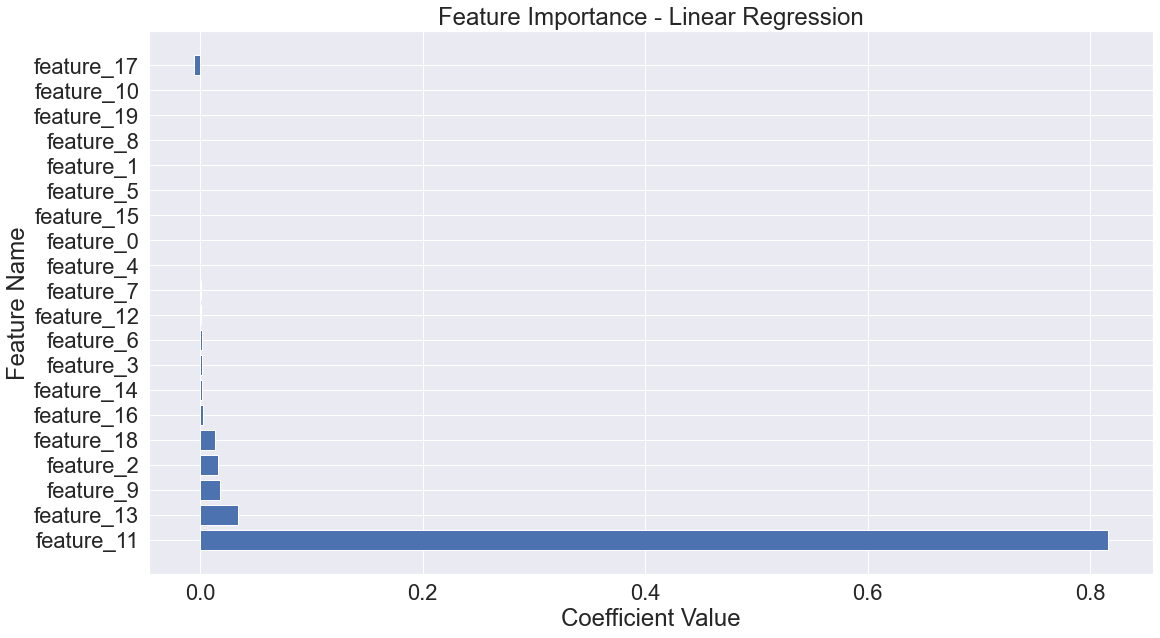

In [42]:
plt.barh(sorted_importance.index, sorted_importance.values)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Name')
plt.title('Feature Importance - Linear Regression')
plt.show()

#### These features match the RFE features

### Plot the Observed and Predicted Target Values

Text(0.5, 1.0, 'Observed vs Predicted Target Values')

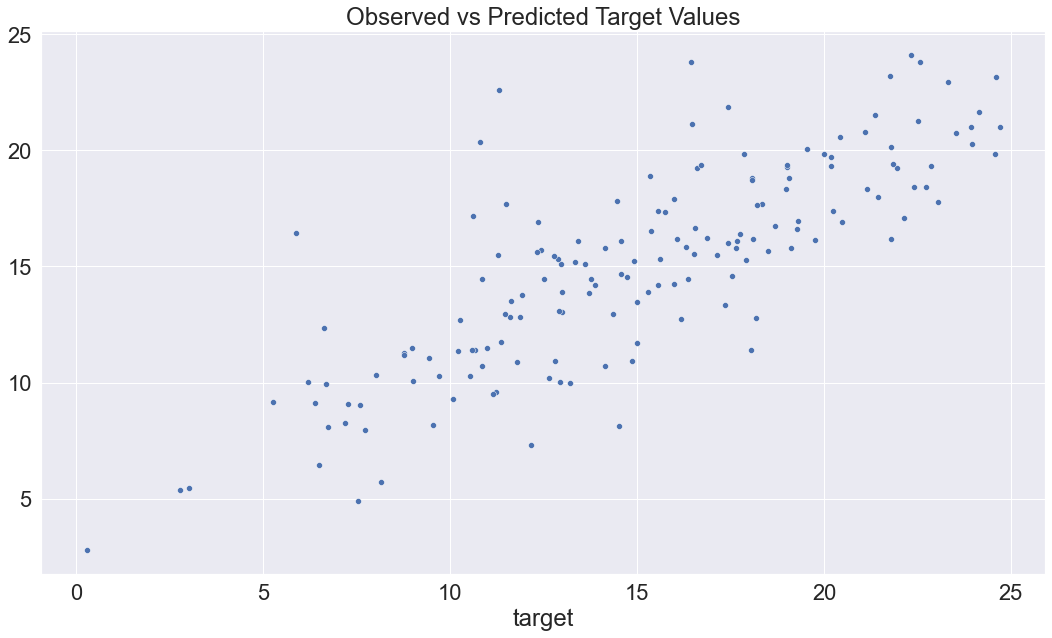

In [43]:
plt.ticklabel_format(style='plain', axis='y')
plt.ticklabel_format(style='plain', axis='x')
sns.scatterplot(x=y_test, y=y_pred).set_title('Observed vs Predicted Target Values')

### Plot the Residuals of the Linear Regression

In [44]:
### We are defining the residuals and we plot them. 
residuals = y_test - y_pred

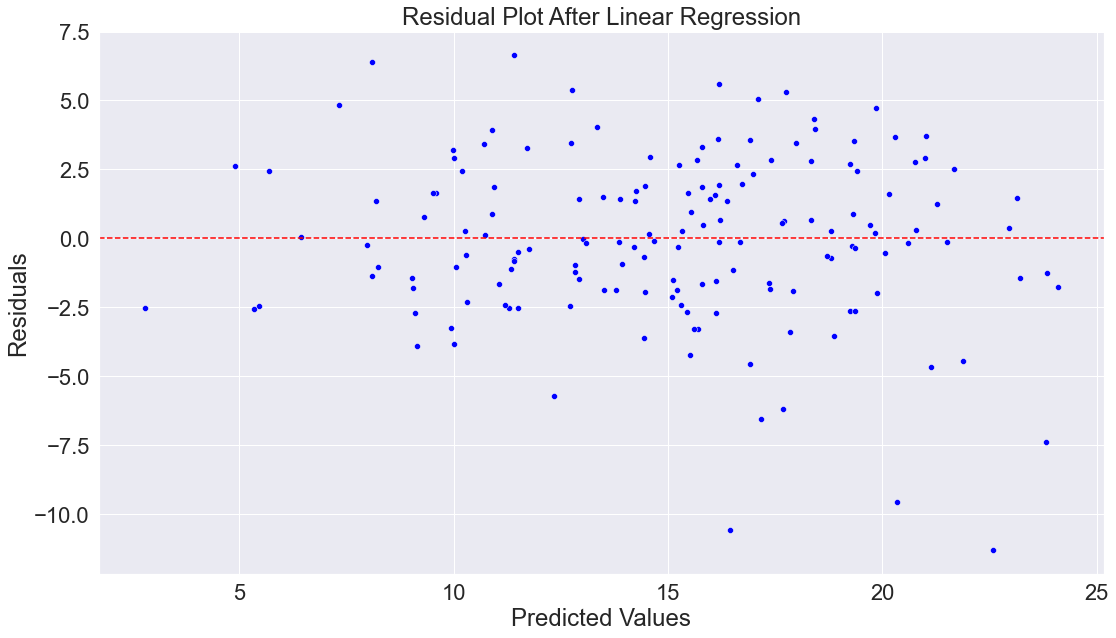

In [45]:
sns.scatterplot(x=y_pred, y=residuals, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residual Plot After Linear Regression")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()

#### There is no discernable pattern in the residual plots, which suggests the errors might be randomly distributed, but this model still returns a relatively low R squared

### Ridge Regression

#### The regularization parameters in Ridge and Lasso need to be tested through cross-validation

In [46]:
# Define the range of alpha values for Ridge and Lasso
alpha_values = [0.01, 0.1, 1, 10, 100]

# Grid for Ridge Regression
param_grid_ridge = {'alpha': alpha_values}

In [47]:
ridge_model = Ridge()

In [48]:
# We do the grid search for Ridge and cross validate
grid_search_ridge = GridSearchCV(estimator=ridge_model, param_grid=param_grid_ridge, cv=15, scoring='neg_mean_squared_error')

# We use the values from the grid search on the training data
grid_search_ridge.fit(X_train, y_train)

# Get the best parameters and best score
best_params_ridge = grid_search_ridge.best_params_
best_score_ridge = -grid_search_ridge.best_score_

print(f'Best alpha for Ridge: {best_params_ridge}')
print(f'Best mean squared error for Ridge: {best_score_ridge}')

Best alpha for Ridge: {'alpha': 10}
Best mean squared error for Ridge: 7.8913742359697405


In [49]:
# We take he best alpha value and use it on the ridge regression model
best_ridge = Ridge(alpha=best_params_ridge['alpha'])

# Train the best Ridge model
best_ridge.fit(X_train, y_train)

# Predict on the test set
y_pred_ridge = best_ridge.predict(X_test)

# Evaluate the best Ridge model
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f'Ridge Regression - MSE: {mse_ridge}')
print(f'Ridge Regression - R²: {r2_ridge}')

Ridge Regression - MSE: 9.100924899753633
Ridge Regression - R²: 0.6554501801238584


#### The MSE and R2 for the Ridge Regression are almost identical to the first linear regression model, no improvement

In [50]:
coefficients_ridge = best_ridge.coef_
feature_importance_ridge = pd.Series(coefficients_ridge, index=X.columns)
sorted_importance_ridge = feature_importance_ridge.sort_values(ascending=False)

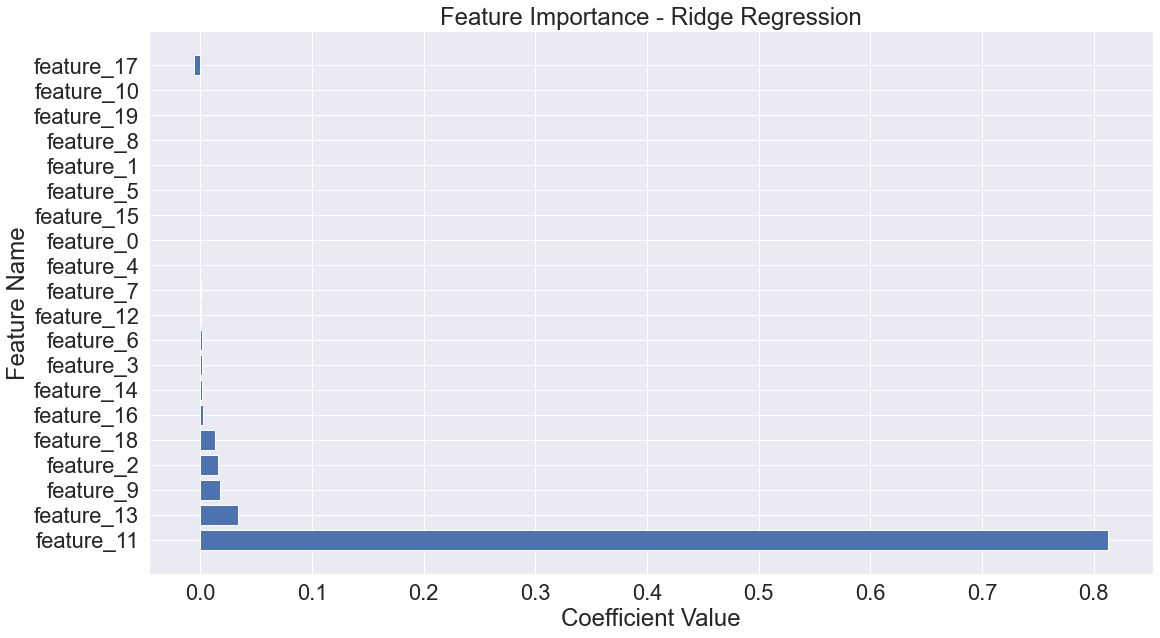

In [51]:
plt.barh(sorted_importance_ridge.index, sorted_importance_ridge.values)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Name')
plt.title('Feature Importance - Ridge Regression')
plt.show()

#### These are the same features that are important in RFE and the first linear regression

### Plot the Observed and Predicted Target Values

Text(0.5, 1.0, 'Observed vs Predicted')

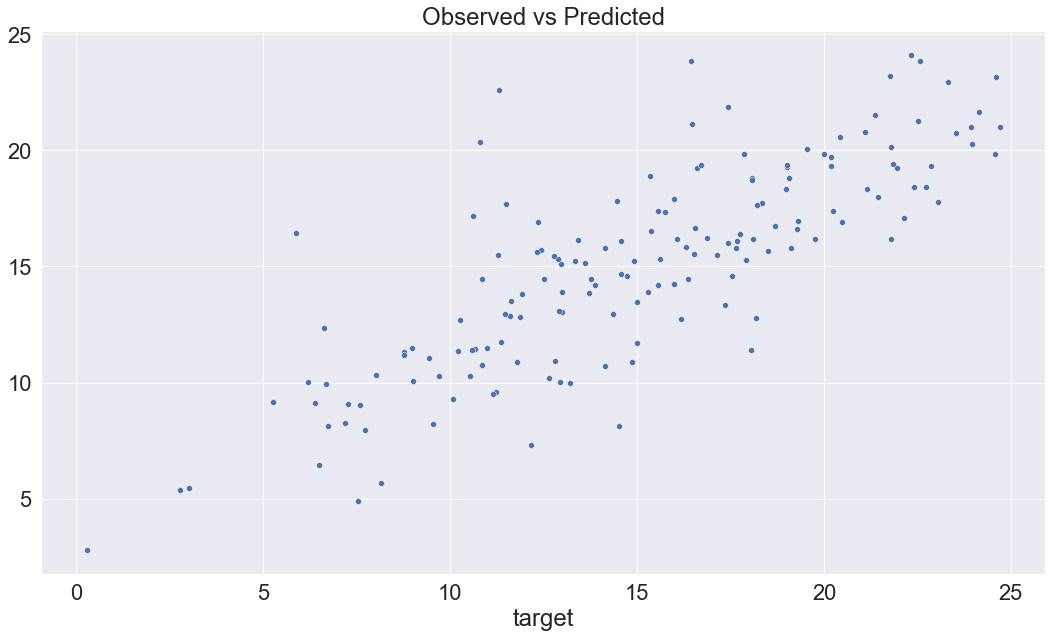

In [52]:
plt.ticklabel_format(style='plain', axis='y')
plt.ticklabel_format(style='plain', axis='x')
sns.scatterplot(x=y_test, y=y_pred_ridge).set_title('Observed vs Predicted')

### Plot the Residuals of the Ridge Regression

In [53]:
### We are defining the residuals and we plot them. 
residuals_ridge = y_test - y_pred_ridge

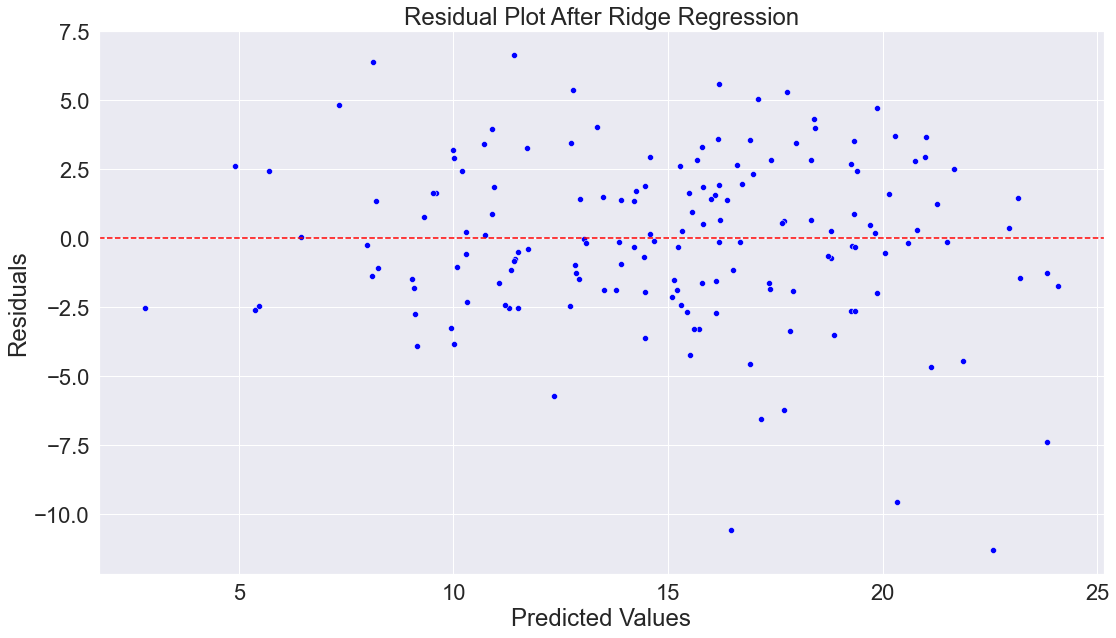

In [54]:
sns.scatterplot(x=y_pred_ridge, y=residuals_ridge, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residual Plot After Ridge Regression")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()

#### The residuals do not show a pattern for the Ridge regression either

### Lasso Regression

In [55]:
alpha_values_lasso = [0.01, 0.1, 1, 10, 100]
param_grid_lasso = {'alpha': alpha_values_lasso}

In [56]:
# We initialize a Lasso model
lasso = Lasso()

# We check the best alpha value with a grid search
grid_search_lasso = GridSearchCV(estimator=lasso, param_grid=param_grid_lasso, cv=15, scoring='neg_mean_squared_error')

# We do the grid search on the training data
grid_search_lasso.fit(X_train, y_train)

# Get the best parameters and best score
best_params_lasso = grid_search_lasso.best_params_
best_score_lasso = -grid_search_lasso.best_score_

print(f'Best alpha for Lasso: {best_params_lasso}')
print(f'Best mean squared error for Lasso: {best_score_lasso}')

Best alpha for Lasso: {'alpha': 0.1}
Best mean squared error for Lasso: 7.888089556577345


In [57]:
# We use the best alpha value to build a lasso model
best_lasso = Lasso(alpha=best_params_lasso['alpha'])

# Train the best Lasso model
best_lasso.fit(X_train, y_train)

# Predict on the test set
y_pred_lasso = best_lasso.predict(X_test)

# Evaluate the best Lasso model
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print(f'Lasso Regression - MSE: {mse_lasso}')
print(f'Lasso Regression - R²: {r2_lasso}')


Lasso Regression - MSE: 9.112665533526059
Lasso Regression - R²: 0.6550056941736853


#### The MSE and R2 metrics for the Lasso regression are also similar to the first linear regression and the ridge regression, there is no improvement

In [58]:
coefficients_lasso = best_lasso.coef_
feature_importance_lasso = pd.Series(coefficients_lasso, index=X.columns)
sorted_importance_lasso = feature_importance_lasso.sort_values(ascending=False)

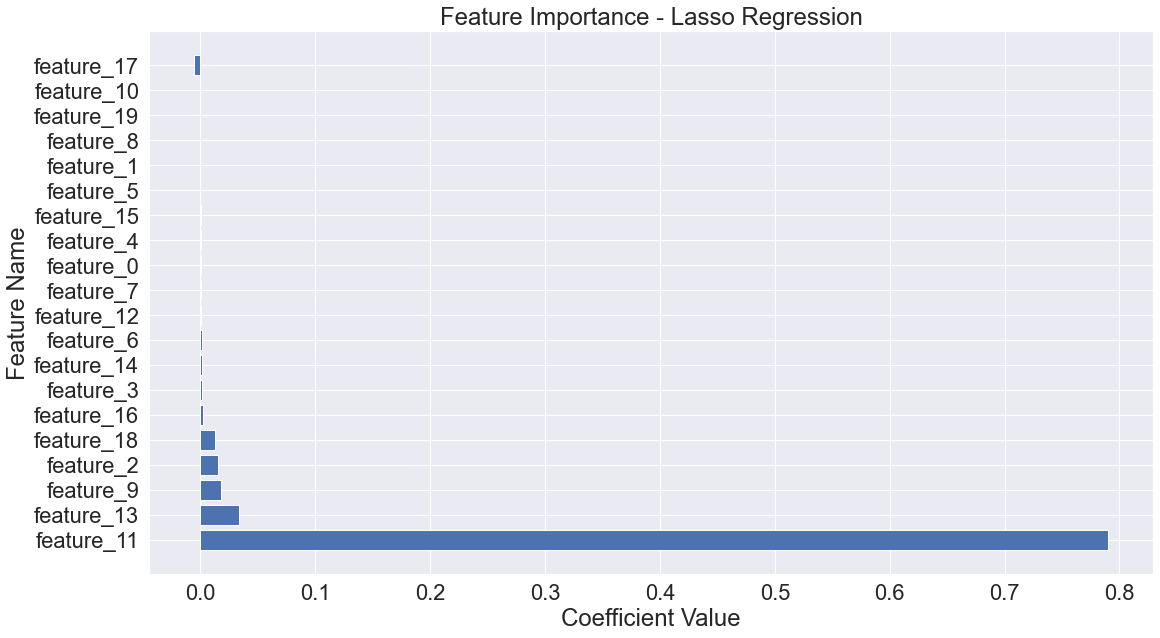

In [59]:
plt.barh(sorted_importance_lasso.index, sorted_importance_lasso.values)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Name')
plt.title('Feature Importance - Lasso Regression')
plt.show()

#### The features match the RFE, the first linear regression, and the ridge regression

### Plot the Observed and Predicted Target Values

Text(0.5, 1.0, 'Observed vs Predicted')

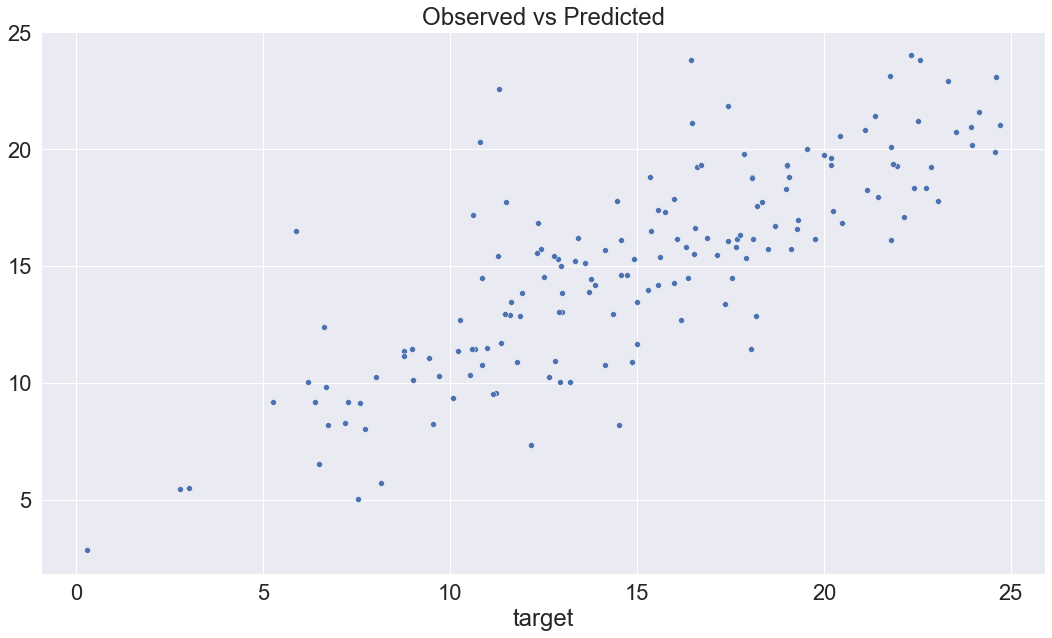

In [60]:
plt.ticklabel_format(style='plain', axis='y')
plt.ticklabel_format(style='plain', axis='x')
sns.scatterplot(x=y_test, y=y_pred_lasso).set_title('Observed vs Predicted')

### Plot the Residuals of the Lasso Regression

In [61]:
### We are defining the residuals and we plot them. 
residuals_lasso = y_test - y_pred_lasso

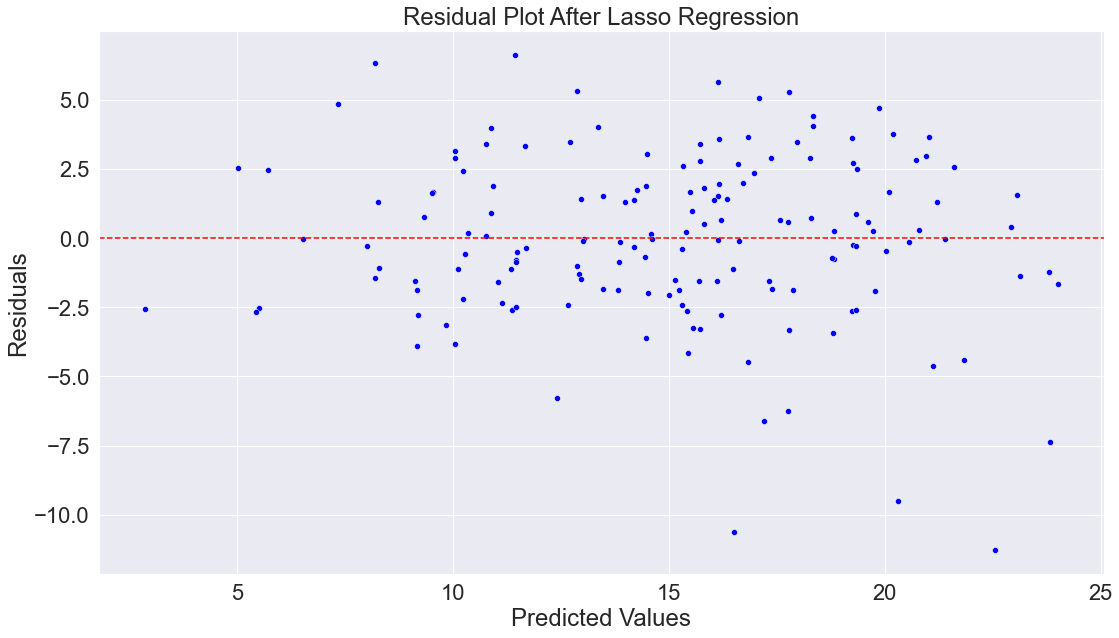

In [62]:
sns.scatterplot(x=y_pred_lasso, y=residuals_lasso, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residual Plot After Lasso Regression")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()

#### There is no pattern in the residuals of the Lasso model either, but the R2 value is not the greatest

### XGBoost Regression Decision Tree

#### Let's see if a decision tree performs better than the linear models

In [63]:
# We initialize an xgboost regression model
xgb_model = XGBRegressor()

In [64]:
# we need to define the hyperparemeters' ranges because we are doing hyperparameter tuning.
# this allows us to create many models so we can try out different values for the parameters
# and find the model with the parameters that have the best evaluation metric

hyperparameters = {
    'n_estimators': [10, 30, 50],
    'max_depth': [5, 7, 9],
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2],
    'min_child_weight': [1, 3, 5],
}

In [65]:
# Perform randomized search cross-validation
search = RandomizedSearchCV(xgb_model, hyperparameters, scoring='neg_mean_squared_error', cv=15, n_iter=10) # cv stands for cross-validation folds, and n_iter is ther number of parameter combinations to try
search.fit(X_train, y_train)

RandomizedSearchCV(cv=15,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate...
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, ...),
                   param_distributions={'learning_rate': [0.0001, 0.001, 0.01,
                                                          0.1, 0.2],
                                        'max_depth': [5, 7, 9],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [10, 30, 50]},
                   scoring='neg_mean_squared_error')

In [66]:
# Get the best model and its hyperparameters
best_model = search.best_estimator_
best_hyperparameters = search.best_params_

In [67]:
# Evaluate the best model on the test set
y_pred_xgb = best_model.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"Best XGBoost Model MSE: {mse_xgb}")
print(f'Test XGBoost R2 (): {r2_xgb}')

Best XGBoost Model MSE: 5.563772776313563
Test XGBoost R2 (): 0.7893624077743446


#### The XGBoost regression model has lower MSE and much higher R2 than the linear regression models. This suggests this model is able to catch the non-linear relationships between the data better

In [68]:
# Retrieve the best hyperparameters
print("Best Hyperparameters:")
for param, value in best_hyperparameters.items():
    print(f"{param}: {value}")

Best Hyperparameters:
n_estimators: 30
min_child_weight: 3
max_depth: 5
learning_rate: 0.1


### Plot the Observed and Predicted Target Values

Text(0.5, 1.0, 'Observed vs Predicted')

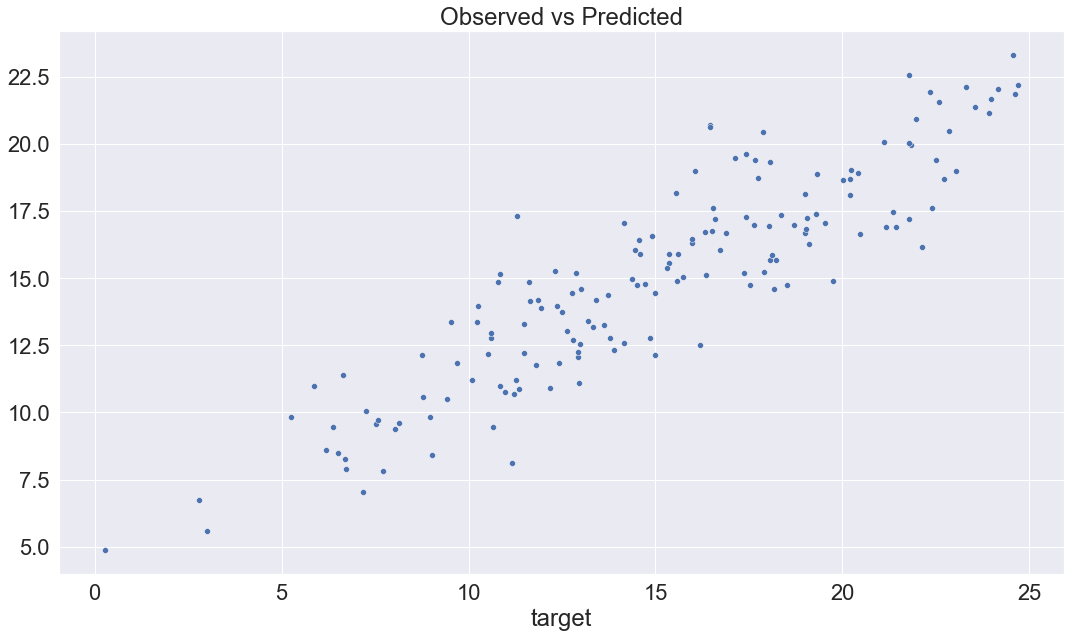

In [69]:
plt.ticklabel_format(style='plain', axis='y')
plt.ticklabel_format(style='plain', axis='x')
sns.scatterplot(x=y_test, y=y_pred_xgb).set_title('Observed vs Predicted')

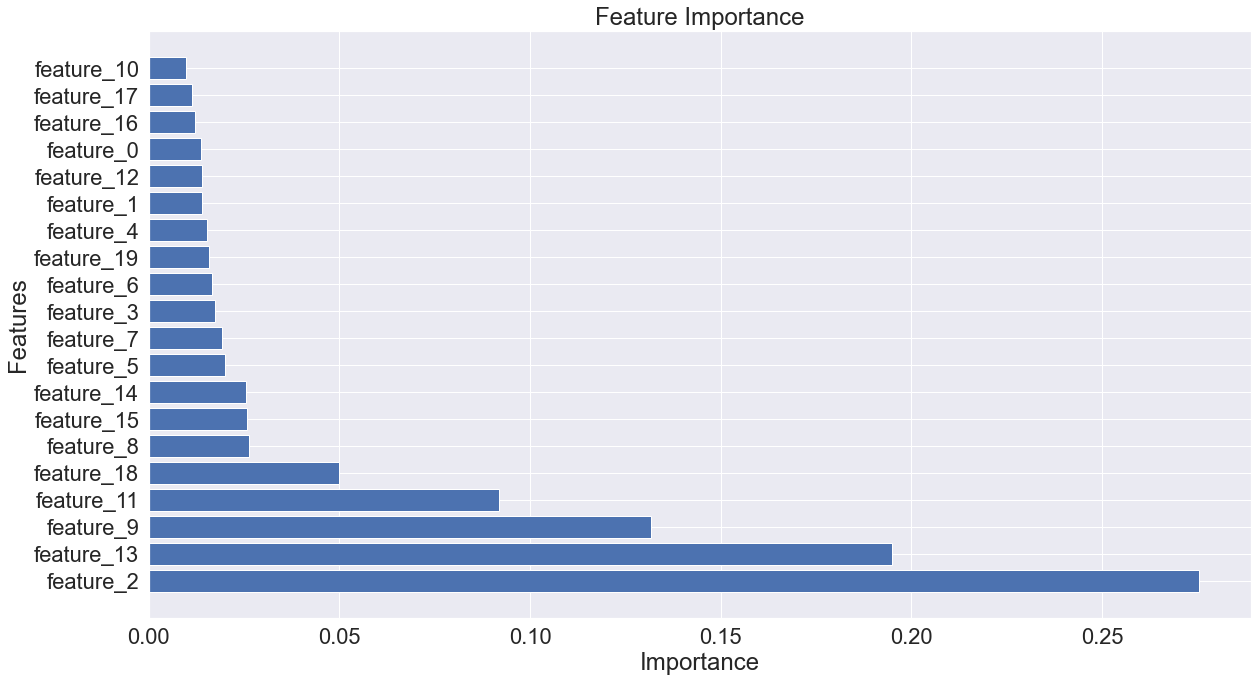

In [70]:
importance = best_model.feature_importances_
feature_names = X_train.columns

# We create a dataframe so we can sort the features by improtance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
})

# Sort the DataFrame by Importance in descending order
importance_df_sorted = importance_df.sort_values(by='Importance', ascending=False)

# Extract sorted feature names and importances
sorted_feature_names = importance_df_sorted['Feature']
sorted_importance = importance_df_sorted['Importance']

# Plot
plt.barh(sorted_feature_names, sorted_importance)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

#### The features from the XGBoost model match all other previous models as well, but the metrics are better

### Plot the Residuals of the XGBoost Regression

In [71]:
### We are defining the residuals and we plot them. 
residuals_xgb = y_test - y_pred_xgb

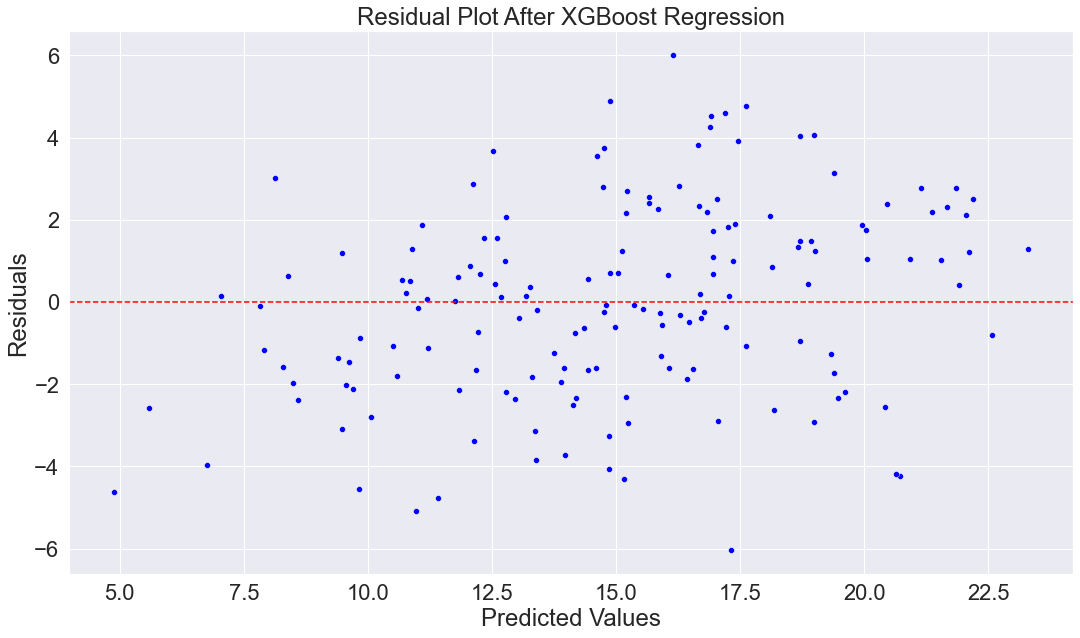

In [72]:
sns.scatterplot(x=y_pred_xgb, y=residuals_xgb, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residual Plot After XGBoost Regression")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()

#### There is no obvious pattern in the residuals

### Plynomial Regression Tests

In [73]:
## Since we have indications of non-linar relationships, let's try a polynomial regression

### Two-Degree Polynomial Regression

In [74]:
degree = 2  

# We create polynomial features
poly_features = PolynomialFeatures(degree=degree, include_bias=False)

In [75]:
# Create a pipeline that first transforms the data, then applies linear regression
poly_model = make_pipeline(poly_features, LinearRegression())

In [76]:
# Fit the model
poly_model.fit(X_train, y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(include_bias=False)),
                ('linearregression', LinearRegression())])

In [77]:
# Predict using the test set
y_pred_poly = poly_model.predict(X_test)

# Evaluate the model
mse_poly = mean_squared_error(y_test, y_pred_poly)
r2_poly = r2_score(y_test, y_pred_poly)

print(f'Mean Squared Error: {mse_poly}')
print(f'R^2 Score: {r2_poly}')

Mean Squared Error: 6.24620860668804
R^2 Score: 0.7635262268342167


#### The MSE and R2 are better than the non-polynomial linear regression model, but not better than the non-polynomial XGBoost model

### Three-degree Polynomial Regression

In [78]:
## Let's see what happens if we have cubed polynomials
degree = 3  

# We create polynomial features
poly_features = PolynomialFeatures(degree=degree, include_bias=False)

# Create a pipeline that first transforms the data, then applies linear regression
poly_model = make_pipeline(poly_features, LinearRegression())

# Fit the model
poly_model.fit(X_train, y_train)

# Predict using the test set
y_pred_poly = poly_model.predict(X_test)

# Evaluate the model
mse_poly = mean_squared_error(y_test, y_pred_poly)
r2_poly = r2_score(y_test, y_pred_poly)

print(f'Mean Squared Error: {mse_poly}')
print(f'R^2 Score: {r2_poly}')

Mean Squared Error: 52.40879761099941
R^2 Score: -0.9841325992354728


#### The cubed polynomial regression makes things a lot worse, oops

### Four-degree Polynomial

In [79]:
## Let's see what happens if we have 4 degree polynomials
degree = 4  

# We create polynomial features
poly_features = PolynomialFeatures(degree=degree, include_bias=False)

# Create a pipeline that first transforms the data, then applies linear regression
poly_model = make_pipeline(poly_features, LinearRegression())

# Fit the model
poly_model.fit(X_train, y_train)

# Predict using the test set
y_pred_poly = poly_model.predict(X_test)

# Evaluate the model
mse_poly = mean_squared_error(y_test, y_pred_poly)
r2_poly = r2_score(y_test, y_pred_poly)

print(f'Mean Squared Error: {mse_poly}')
print(f'R^2 Score: {r2_poly}')

Mean Squared Error: 57.73231882196014
R^2 Score: -1.1856745627773315


#### This doesn't work either

### XGBoost Polynomial

In [80]:
## Finally, let's see how XGBoost does with squared polynomials

degree = 2 

# Create polynomial features
poly_features = PolynomialFeatures(degree=degree, include_bias=False)

# Transform the features
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

In [81]:
# We initialize the model
xgb_model_poly = XGBRegressor()

In [82]:
hyperparameters = {
    'n_estimators': [10, 30, 50],
    'max_depth': [5, 7, 9],
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2],
    'min_child_weight': [1, 3, 5],
}

In [83]:
# Perform randomized search cross-validation
search = RandomizedSearchCV(xgb_model_poly, hyperparameters, scoring='neg_mean_squared_error', cv=15, n_iter=10) # cv stands for cross-validation folds, and n_iter is ther number of parameter combinations to try
search.fit(X_train_poly, y_train)

RandomizedSearchCV(cv=15,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate...
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, ...),
                   param_distributions={'learning_rate': [0.0001, 0.001, 0.01,
                                                          0.1, 0.2],
                                        'max_depth': [5, 7, 9],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [10, 30, 50]},
                   scoring='neg_mean_squared_error')

In [84]:
# Get the best model and its hyperparameters
best_model_poly = search.best_estimator_
best_hyperparameters_poly = search.best_params_

In [85]:
# Evaluate the best model on the test set
y_pred_xgb_poly = best_model_poly.predict(X_test_poly)
mse_poly = mean_squared_error(y_test, y_pred_xgb_poly)
r2_poly = r2_score(y_test, y_pred_xgb_poly)
print(f"Best Model MSE: {mse_poly}")
print(f'Test R2 (Ridge): {r2_poly}')

Best Model MSE: 4.317995555616361
Test R2 (Ridge): 0.8365260006756158


#### It looks like there is a slight improvement with the polynomial XGBoost model too

### Reduced Features XGBoost Regression Model

#### Finally, let's see what happens when we build an XGBoost model using just the features that RFE found important

In [86]:
## Let's see how XGBoost performs on just the important metrics
columns_to_keep = ['feature_2', 'feature_9', 'feature_11', 'feature_13', 'feature_18','target']
reduced_df = train_df.loc[:, train_df.columns.isin(columns_to_keep)]

In [87]:
X_reduced = reduced_df.loc[:, ~reduced_df.columns.isin(columns_to_exclude)]
y_reduced = reduced_df['target']

In [88]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_reduced, test_size=0.2, random_state=23)

In [89]:
## Decision Tree, XGBoost

# initialize the model
xgb_model_reduced = XGBRegressor()

In [91]:
hyperparameters = {
    'n_estimators': [10, 30, 50],
    'max_depth': [5, 7, 9],
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2],
    'min_child_weight': [1, 3, 5],
}

In [92]:

# Perform randomized search cross-validation
search = RandomizedSearchCV(xgb_model_reduced, hyperparameters, scoring='neg_mean_squared_error', cv=15, n_iter=10) # cv stands for cross-validation folds, and n_iter is ther number of parameter combinations to try
search.fit(X_train, y_train)

RandomizedSearchCV(cv=15,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate...
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, ...),
                   param_distributions={'learning_rate': [0.0001, 0.001, 0.01,
                                                          0.1, 0.2],
                                        'max_depth': [5, 7, 9],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [10, 30, 50]},
                   scoring='neg_mean_squared_error')

In [93]:
# Get the best model and its hyperparameters
best_model_reduced = search.best_estimator_
best_hyperparameters_reduced = search.best_params_

In [94]:
# Evaluate the best model on the test set
y_pred_xgb_reduced = best_model_reduced.predict(X_test)
mse_reduced = mean_squared_error(y_test, y_pred_xgb_reduced)
r2_reduced = r2_score(y_test, y_pred_xgb_reduced)
print(f"Best Model MSE: {mse_reduced}")
print(f'Test R2: {r2_reduced}')

Best Model MSE: 3.9769747573373957
Test R2: 0.8494366285420446


#### The reduced XGBoost model performs slightly better than the full XGBoost and the polynomial XGBoost model. However, at this stage and with blind features, it is not clear whether we should use the reduced version of the dataset for only a slightly improved R2

In [95]:
# Retrieve the best hyperparameters
print("Best Hyperparameters:")
for param, value in best_hyperparameters_reduced.items():
    print(f"{param}: {value}")

Best Hyperparameters:
n_estimators: 50
min_child_weight: 1
max_depth: 5
learning_rate: 0.2


## 4. Use the XGBoost Model on Blind Test Data

In [96]:
## It looks like all 4 models show feature_18, feature_11, feature_9, feature_13, and feature_2 have the most feature importance.
## However, since XGBoost's R squared is the highest, we are going to use this model to test the blind test csv.

### Health Check for the Test Data

In [97]:
# 4. Test the XGBoost model 
test_df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19
0,676.867615,32.518822,254.825875,502.268510,609.469688,497.624266,105.246239,269.045539,150.177005,312.649860,765.296227,0.237996,660.030637,147.059794,40.232132,464.424834,121.147466,68.284243,26.969870,314.461582
1,628.695228,426.163933,347.070280,431.106903,915.527507,301.699534,1.666992,306.733041,104.234252,63.242070,467.009734,6.608084,600.994184,43.619815,48.153926,457.256565,49.163652,85.511662,33.500538,819.537877
2,131.765943,323.839669,245.399775,181.814398,710.179159,59.117377,312.622788,687.965027,109.803179,381.169500,700.532108,1.822370,736.306092,138.759029,36.915389,436.174065,10.037994,62.631938,6.211169,341.361374
3,160.970195,489.712029,70.482159,309.486269,888.030604,412.655666,216.124989,47.415477,104.139145,326.462385,378.446187,1.686895,485.144327,143.668518,27.168148,309.715497,149.661493,66.415878,15.001753,539.087409
4,419.907137,216.625219,487.887860,253.704462,323.226862,65.744463,271.811469,527.726782,129.805782,168.429679,637.944633,0.948507,365.946758,72.337904,36.232169,302.772338,186.944884,106.514846,3.443809,364.341969


In [98]:
test_df.isnull().sum()

feature_0     0
feature_1     0
feature_2     0
feature_3     0
feature_4     0
feature_5     0
feature_6     0
feature_7     0
feature_8     0
feature_9     0
feature_10    0
feature_11    0
feature_12    0
feature_13    0
feature_14    0
feature_15    0
feature_16    0
feature_17    0
feature_18    0
feature_19    0
dtype: int64

In [99]:
test_df.describe()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,479.418943,302.789598,298.881139,277.122164,487.197330,329.547672,216.553551,407.437369,185.323348,185.330621,399.885263,3.435991,484.111468,103.000612,28.385030,302.016127,88.064593,72.288016,25.734867,486.748986
std,276.105184,173.501362,176.618705,159.957989,285.241709,202.975647,130.027533,232.777723,106.819818,109.137554,233.616342,2.072470,275.238131,58.422820,16.078995,167.512763,55.506339,36.787387,15.358787,275.182274
min,8.902448,0.527684,0.701631,0.363441,18.294208,3.433068,1.666992,1.543639,1.277293,0.161765,0.018962,0.024754,1.558625,0.451144,0.046261,0.472701,1.772818,0.261328,0.115756,6.651236
25%,253.260644,149.077628,143.306169,146.075993,228.431904,132.525784,101.393680,215.300572,100.873230,97.411249,180.199061,1.756698,249.496452,53.079222,13.653160,165.629359,36.725569,43.765638,12.032488,262.851112
50%,447.736103,310.756224,276.178520,272.779697,473.720044,324.481500,204.226392,403.817443,186.137427,183.374303,419.738245,3.328098,474.878563,108.471506,27.977327,302.722449,82.584776,71.373552,25.854130,465.275656
75%,702.238048,461.389162,449.147430,424.683132,735.828374,525.452626,335.151779,603.103185,277.393851,287.737222,615.239423,5.323293,719.416216,150.305452,41.433831,447.837714,135.406461,103.581011,38.911829,738.309590
max,934.240319,592.806848,616.165779,549.072116,945.325628,637.718755,426.167584,806.555211,365.975352,384.098819,765.296227,6.877732,978.361203,200.311860,56.351806,566.019624,187.124657,137.775278,52.954718,935.870211


### Check if Test Data Distribution is Similar to Training Data Distribution

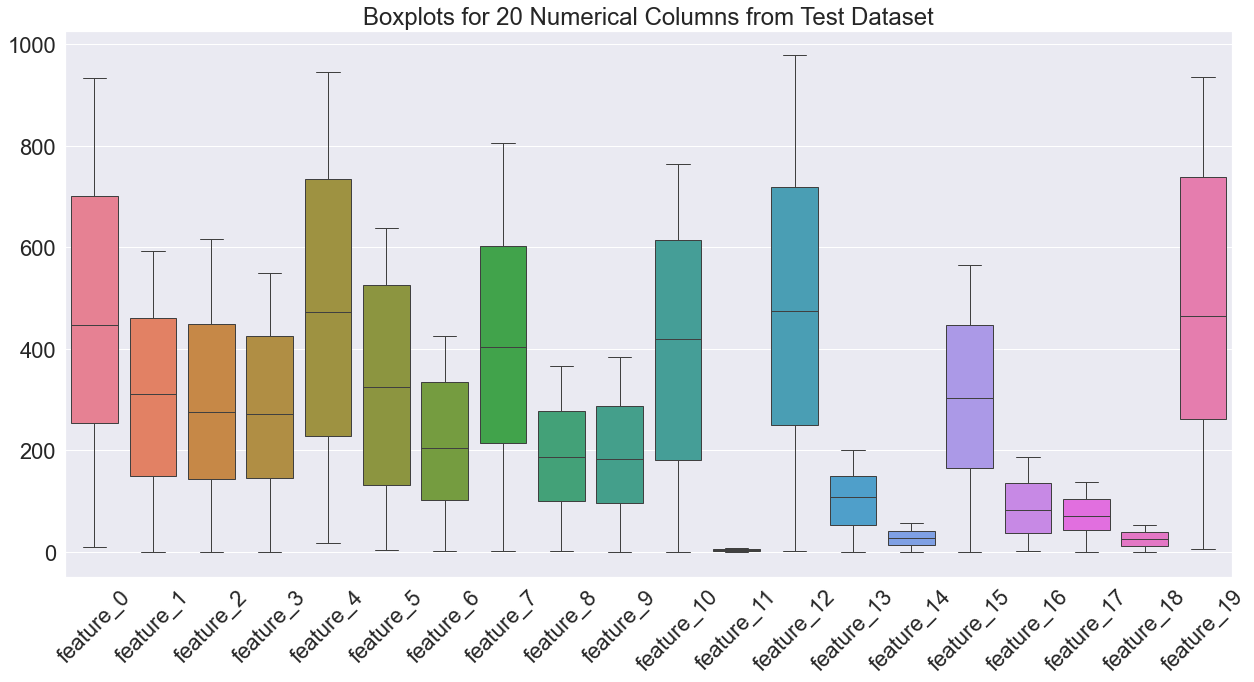

In [100]:
## Let's visualize the spread of the test features data with boxplots

sns.boxplot(data=test_df)

# Name the chart and set the labels to 45 degree angle
plt.title('Boxplots for 20 Numerical Columns from Test Dataset')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

### Use the XGBoost Trained Model to Predict

#### In other circumstance, when I know the underlying data better and I know what the features are, I would be more confident to use the polynomial XGBoost since it has a higher R2 than the non-polynomial XGBoost model. However, what if what I'm squaring is something that shouldn't be squared? :) For this exercise, I would rather sacrifice a bit of the explained variance but predict using a model that doesn't alter the test data by squaring them

In [105]:
test_predictions = best_model.predict(test_df)

In [106]:
test_predictions

array([13.405225 , 12.4200535, 14.800217 , 12.568072 , 17.037125 ,
       10.429299 , 17.790121 , 17.486921 , 12.52891  ,  9.957032 ,
       17.061644 , 17.855364 , 20.981548 , 19.69217  , 11.132846 ,
       12.967471 ,  8.509627 , 19.253038 , 14.185867 , 16.928059 ,
       13.993715 , 21.267143 , 11.245349 , 14.049405 , 14.422799 ,
       19.083942 ,  8.376789 , 21.656212 , 17.709976 , 14.376344 ,
       19.61393  , 21.973919 , 18.804907 ,  9.378898 ,  6.556669 ,
       16.929073 , 15.078765 , 21.413189 ,  9.541242 , 19.285385 ,
        9.102975 ,  8.090643 , 17.759842 , 10.605131 , 11.723917 ,
       16.261673 , 17.368942 , 19.018845 , 17.385113 , 13.201106 ,
       17.902233 , 18.039293 , 15.542225 , 19.52412  , 14.541137 ,
        9.867748 ,  8.067559 , 15.691696 , 16.87768  , 15.433393 ,
       18.021582 ,  9.288856 , 15.067579 , 12.661527 , 16.29456  ,
       13.39026  , 10.187343 , 16.191772 , 20.091955 , 15.273053 ,
       10.883838 , 13.569648 , 15.080768 , 13.562731 , 20.9626

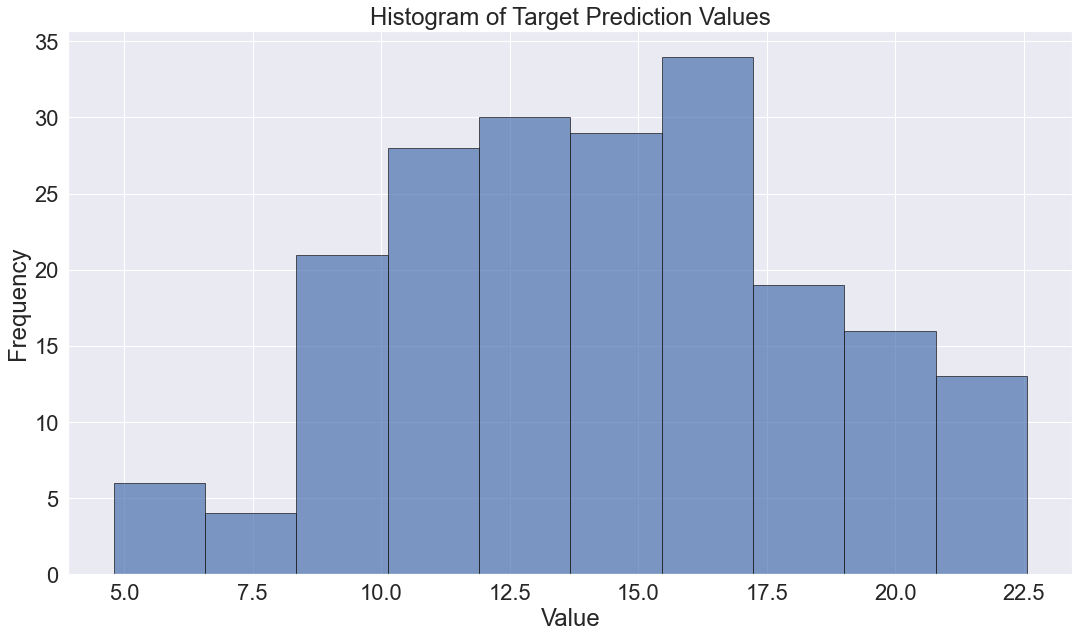

In [108]:
plt.hist(test_predictions, edgecolor='k', alpha=0.7) 
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Target Prediction Values')
plt.grid(True)
plt.show()

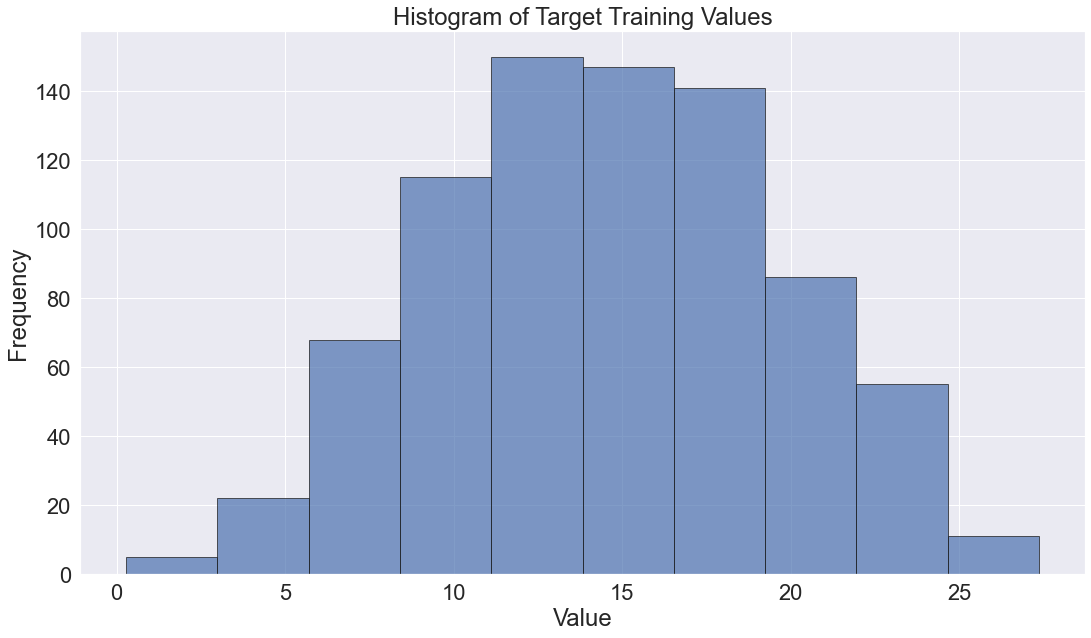

In [109]:
plt.hist(train_df.target, edgecolor='k', alpha=0.7)  # bins specify the number of bins
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Target Training Values')
plt.grid(True)
plt.show()

#### The predicted target values seem to have a similar distribution to the training target values

In [110]:
predictions_df = pd.DataFrame(test_predictions, columns=['target_pred'])

In [111]:
predictions_df.to_csv('target_pred.csv', index=False)